In [1]:
#%%
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib

import pandas_datareader
import pandas_datareader.data as web
import investpy
import yfinance as yf

from constants import *
import time
import datetime as dt

import requests
from bs4 import BeautifulSoup as bs
import etl_processor


pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None


etf_meta = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_META_ETF))
etf_info = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_INFO_ETF))
etf_profile = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_PROFILE_ETF))

In [ ]:
# 오늘의 ETF
investpy.etfs.get_etfs_overview(country='united states')

Todo
- History 지표 추가
- Summary 계산
- 함수 기능위주 분리


# Test

In [2]:
import etl_processor
processor = etl_processor.EtlProcessor()
master_etf = pd.read_csv(os.path.join(processor.dir_download, processor.fname_master_etf))
master_indices_yahoo = pd.read_csv(os.path.join(processor.dir_download, processor.fname_master_indices_yahoo))
master_indices_investpy = pd.read_csv(os.path.join(processor.dir_download, processor.fname_master_indices_investpy))
master_currencies = pd.read_csv(os.path.join(processor.dir_download, processor.fname_master_currencies))
master_indices_fred = pd.read_csv(os.path.join(processor.dir_download, processor.fname_master_indices_fred))

In [ ]:
# processor.get_meta_etf()
# processor.get_info_etf() -> 돈거 확인, 에러난거 재시도 하는 방법 찾아보기
# processor.get_profile_etf()  -> 돌려보기

# processor.get_master_indices_investpy()

# processor.get_history_from_fred(master_indices_fred)
# processor.get_history_from_yf(master_indices_yahoo)
# processor.get_history_from_yf(master_indices_investpy)

In [21]:
df = pd.read_csv(os.path.join('download', 'history_etf', 'GLD_history.csv'))
df.head()

,symbol,full_name,date,open,high,low,close,volume,dividends,stock_splits
0,GLD,SPDR® Gold Shares,2004-11-18,44.430000,44.490002,44.070000,44.380001,5992000,0,0
1,GLD,SPDR® Gold Shares,2004-11-19,44.490002,44.919998,44.470001,44.779999,11655300,0,0
2,GLD,SPDR® Gold Shares,2004-11-22,44.750000,44.970001,44.740002,44.950001,11996000,0,0
3,GLD,SPDR® Gold Shares,2004-11-23,44.880001,44.919998,44.720001,44.750000,3169200,0,0
4,GLD,SPDR® Gold Shares,2004-11-24,44.930000,45.049999,44.790001,45.049999,6105100,0,0


In [ ]:

def preprocess_etf_history(df):
    df['date'] = pd.to_datetime(df['date'])
    df['dividends_trailing_12m'] = df.set_index('date')['Dividends'].rolling(window='365d').sum().to_numpy()
    df['dividends_trailing_6m'] = (df.set_index('date')['Dividends'].rolling(window='183d').sum().to_numpy())*2
    df['dividends_rate_trailing_12m'] = df['dividends_trailing_12m']/df['Close']
    # df['Recent_Yearly_Dividends_Rate'].plot(figsize=(20,6))
    df['Change'] = df['Close'].diff().fillna(0)
    df['Change_Rate'] = df['Change']/df['Close']
    df['Change_Sign'] = np.sign(df['Change'])
    df['All_Time_High'] = df['Close'].cummax()
    df['Drawdown'] = (df['Close']/df['All_Time_High']) - 1
    df['Bull_Bear'] = df['Drawdown'].apply(lambda x: 'Bear' if x>=-0.03 else 'Bull') # 일주일 이동평균 이용해도 괜찮을듯 # B_B_w, B_B_m
    df['Drawdown_All_time'] = df['Drawdown'].cummin()
    df['Drawdown_Max'] = df['Drawdown'].max()
    # df['Drawdown_00']
    # df['Drawdown_08']
    # df['Drawdown_20']
    # df['Drawdown_22']
    return df

def summarize_history(df): # 모든 preprocessed column의 최신값
    df['All_Time_High'] = df['Close'].cummax()
    pass

# Get ETF Meta
Meta 테이블은 데이터를 한번 불러오는데 시간이 오래걸리므로
- 1주일~1달에 1번만 실행
- 분산처리 공부

In [ ]:
etf_meta = investpy.etfs.get_etfs(country='united states')
etf_meta

In [ ]:
def get_etf_meta(fpath):
    etf_meta = investpy.etfs.get_etfs(country='united states')
    etf_meta.to_csv(fpath, index=False)
    return etf_meta

etf_meta = get_etf_meta(fpath=os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_META))
etf_meta


In [7]:
investpy.etfs.get_etf_information('ishares S&P 500', country='united states')

,ETF Name,Prev. Close,Todays Range,ROI (TTM),Open,52 wk Range,Dividends (TTM),Volume,Market Cap,Dividend Yield,Average Vol. (3m),Total Assets,Beta,1-Year Change,Shares Outstanding,Asset Class
0,ishares S&P 500,391.1,382.17 - 395.49,12.12%,394.91,382.17 - 482.07,5.9245,7433555.0,2.817200e+11,1.51%,7559268.0,6.926000e+10,1.01,- 6.12%,719950000.0,Equity


In [ ]:
def get_etf_info(fpath, etf_meta):
    
    header = investpy.etfs.get_etf_information(etf_names[0], country='united states').columns.to_list()
    rows = []
    etf_names = etf_meta['name']


    for i, name in enumerate(tqdm((etf_names[:]), mininterval=0.5)):
        try:
            time.sleep(0.5)
            row = investpy.etfs.get_etf_information(name, country='united states').iloc[0].to_list()
            rows.append(row)
        except:
            print(f'Loop No.{i} | Error Ocurred While Getting Information of: {name}')
    
    etf_info = pd.DataFrame(rows, columns=header) 
    os.makedirs(DIRNAME_DOWNLOAD, exist_ok=True)
    etf_info.to_csv(fpath, index=False)

    return etf_info

etf_info = get_etf_info(fpath=os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_INFO), etf_meta=etf_meta)
etf_info

# Get ETF Profile

In [ ]:
def get_etf_profile(fpath, etf_meta):
    
    header = COLS_ETF_PROFILE
    rows = []
    symbols = etf_meta['symbol']

    for i, symbol in enumerate(tqdm((symbols[:]), mininterval=0.5)):
        try:
            # time.sleep(0.5)
            etf = yf.Ticker(symbol)
            temp_df = etf.get_institutional_holders().T
            temp_df.columns = temp_df.iloc[0]
            temp_df = temp_df[1:]

            temp_df['Symbol'] = symbol
            temp_df['Fund Family'] = etf.info.get('fundFamily')

            row = temp_df[COLS_ETF_PROFILE].iloc[0].to_list()
            rows.append(row)
        except:
            print(f'Loop No.{i} | Error Ocurred While Getting Profile of: {symbol}')
        
    etf_profile = pd.DataFrame(rows, columns=header)
    os.makedirs(DIRNAME_DOWNLOAD, exist_ok=True)
    etf_profile.to_csv(fpath, index=False)
    
    return etf_profile

get_etf_profile(fpath=os.path.join(DIRNAME_DOWNLOAD,FNAME_ETF_PROFILE), etf_meta=etf_meta)

In [2]:
etf = yf.Ticker('KRW=X')
temp_df = etf.get_institutional_holders().T
temp_df.columns = temp_df.iloc[0]
temp_df = temp_df[1:]
temp_df

,Day's Range,52 Week Range,Ask
1,"1,273.8700 - 1,273.8700","1,104.0000 - 1,291.5000",1274.8700


In [ ]:
symbols = etf_meta['symbol']
symbol = symbols[0]
etf = yf.Ticker(symbol).history(period='max').reset_index()


# Construct ETF Master
다음 3개의 테이블을 병합하여 생성
- `etf_meta`
- `etf_info`
- `etf_profile`

In [76]:
etf_meta = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_META))
etf_info = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_INFO))
etf_profile = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_PROFILE))

In [79]:
etf_profile.head()

,Symbol,Fund Family,Expense Ratio (net),Inception Date,Net Assets,NAV
0,SPDV,AAM,0.29%,2017-11-28,60.62M,31.57
1,EEMD,AAM,0.49%,2017-11-28,7.25M,20.08
2,ZIG,Acquirers Funds,0.89%,2019-05-14,41.75M,26.77
3,HDGE,AdvisorShares,5.20%,2011-01-26,122.66M,28.86
4,DWSH,AdvisorShares,3.68%,2018-07-10,32.13M,9.44


In [81]:
a = etf_meta.merge(etf_profile, how='left', left_on='symbol', right_on='Symbol')
a.head()

,country,name,full_name,symbol,isin,asset_class,currency,stock_exchange,def_stock_exchange,Symbol,Fund Family,Expense Ratio (net),Inception Date,Net Assets,NAV
0,united states,AAM S&P 500 Sector High Dividend,AAM S&P 500 Sector High Dividend,SPDV,US26922A5948,equity,USD,NYSE,True,SPDV,AAM,0.29%,2017-11-28,60.62M,31.57
1,united states,AAM S&P EM Sector High Dividend,AAM S&P Emerging Markets Sector High Dividend,EEMD,US26922A5864,equity,USD,NYSE,True,EEMD,AAM,0.49%,2017-11-28,7.25M,20.08
2,united states,The Acquirers Fund,The Acquirers Fund ETF,ZIG,US26922A2630,equity,USD,NYSE,True,ZIG,Acquirers Funds,0.89%,2019-05-14,41.75M,26.77
3,united states,Ranger Equity Bear,Ranger Equity Bear,HDGE,US00768Y8839,equity,USD,NYSE,True,HDGE,AdvisorShares,5.20%,2011-01-26,122.66M,28.86
4,united states,AdvisorShares Dorsey Wright Short,AdvisorShares Dorsey Wright Short,DWSH,US00768Y5298,equity,USD,NASDAQ,True,DWSH,AdvisorShares,3.68%,2018-07-10,32.13M,9.44


In [8]:
#etf_meta.head(2)
#etf_info.head(2)
etf_profile.head(2)

,symbol,fund_family,expense_ratio,inception_date,net_assets,nav
0,SPDV,AAM,0.29,2017-11-28,60.62M,31.57
1,EEMD,AAM,0.49,2017-11-28,7.25M,20.08


In [ ]:
a = construct_etf_master()
a

In [9]:
print(a['total_assets'].isnull().sum())
print(a['total_assets'].notnull().sum())

637
1531


In [ ]:
def construct_etf_master():
    etf_meta = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_META))
    etf_info = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_INFO))
    etf_profile = pd.read_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_PROFILE))

    etf_meta.rename(columns={'asset_class': 'category'}, inplace=True)

    etf_info = etf_info[DICT_COLS_ETF_INFO.keys()]
    etf_info.rename(columns=DICT_COLS_ETF_INFO, inplace=True)
    etf_info['dividend_yield_rate'] = etf_info['dividend_yield_rate'].str.replace('%','').astype('float32')/100
    etf_info['1_year_change_rate'] = etf_info['1_year_change_rate'].str.replace('[ %]','', regex=True).astype('float32') /100 # 공백과 %기호 제거

    etf_profile = etf_profile[DICT_COLS_ETF_PROFILE.keys()]
    etf_profile.rename(columns=DICT_COLS_ETF_PROFILE, inplace=True)
    etf_profile['expense_ratio'] = etf_profile['expense_ratio'].str.replace('%','').astype('float32')

    etf_master = etf_meta.merge(etf_info, how='left', left_on='name', right_on='etf_name')
    etf_master = etf_master.merge(etf_profile, how='left', left_on='symbol', right_on='symbol')
    etf_master = etf_master[COLS_ETF_MASTER]
    etf_master.to_csv(os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_MASTER), index=False)

    return etf_master

construct_etf_master()

# Get ETF History
- 모듈별 특징
    - investpy
        - 응답시간으로 유추해보면 일자에 일일이 요청을 날려 데이터를 받아오는 듯 함
        - 1700년쯤으로 설정하면 너무 많이 시도해서 막힘
        - 적당히 1970-1990년 정도로 하기
    - pandas datareader - yahoo finance
        - 단순 입력으로 얻을 수 있는 가장 과거날짜: https://github.com/ranaroussi/yfinance/issues/25
        - 유닉스타임으로 날짜 바꾸기: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=tamiel&logNo=221872429636 -> 잘안됨
    - yfinance
        - price, divdidend, split의 history를 한방에 획득 가능!!
        - `period="max"`와 같이 쉽게 히스토리 데이터 획득 가능
        - `pip install yfinance`로 설치 시 S&P500 1950년부터 획득 가능
        - `pip install yfinance==0.1.63`으로 설치 시 S&P500 1927년부터 획득 가능: https://github.com/ranaroussi/yfinance/issues/980
- 저장 방식(2안으로 결정)
    - 1안: 통째로 저장 -> 통째로 로드 -> 통째로 전처리
    - 2안: 종목별 저장 -> 종목별 로드 -> 종목별 전처리 -> 하나로 합치기
    - 3안: 종목별 전처리 후 저장 -> 하나로 합치기





In [2]:
def get_etf_history(fpath, etf_meta):
    symbols = etf_meta['symbol'].to_list()
    names = etf_meta['full_name'].to_list()
    os.makedirs(fpath, exist_ok=True)

    for symbol, name in tqdm(zip(symbols, names[:]), total=len(symbols)):
        try:
            history =  yf.Ticker(symbol).history(period='max').reset_index()

            if len(history) >= 1:
                history['symbol'] = symbol
                history['full_name'] = name
                history.rename(columns=DICT_COLS_HISTORY, inplace=True)
                history[COLS_HISTORY].to_csv(os.path.join(fpath, f'{symbol}_history.csv'), index=False)
        
        except:
            print(f'Error Occured...: {symbol} - {name}')

get_etf_history(fpath=os.path.join(DIRNAME_DOWNLOAD, SUBDIRNAME_ETF_HISTORY), etf_meta=etf_meta)

  0%|          | 0/2164 [00:00<?, ?it/s]

- AGO_PF: No data found, symbol may be delisted
- GAZZF: No data found, symbol may be delisted
- DLBLF: No data found, symbol may be delisted
- ADZCF: No data found, symbol may be delisted
- EVVLF: No data found, symbol may be delisted
- NHF: No data found, symbol may be delisted
- AFC: No data found, symbol may be delisted
- RPIBC: No data found, symbol may be delisted
- SXNEMG: No data found, symbol may be delisted
- SXNNDQ: No data found, symbol may be delisted
- SXNWDM: No data found, symbol may be delisted
- USUTF: No data found, symbol may be delisted
- TUTT: No data found, symbol may be delisted


In [11]:
a = yf.Ticker('^DJI').history(period='max').reset_index()
a.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [15]:
a.columns.str.lower()

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits'], dtype='object')

In [110]:
symbols = etf_meta['symbol'].to_list()
names = etf_meta['full_name'].to_list()
os.makedirs(os.path.join(DIRNAME_DOWNLOAD, SUBDIRNAME_ETF_HISTORY))

for symbol, name in tqdm(zip(symbols, names[:2]), total=len(symbols)):
    print(symbol, name)
    
    history =  yf.Ticker(symbol).history(period='max').reset_index()
    history['symbol'] = symbol
    history['full_name'] = name

    history.to_csv(os.path.join(DIRNAME_DOWNLOAD, SUBDIRNAME_ETF_HISTORY, f'{symbol}_history.csv'), index=False)


  0%|          | 0/2164 [00:00<?, ?it/s]

SPDV AAM S&P 500 Sector High Dividend
EEMD AAM S&P Emerging Markets Sector High Dividend


In [ ]:
etf_symbols = etf_meta['symbol']

heaader = yf.Ticker('aapl').history(start=dt.datetime.today() - dt.timedelta(days=10)).reset_index().columns.to_list()
time.sleep(0.1)

count=0
for symbol in tqdm(etf_symbols[:], mininterval=0.5):
    data =  yf.Ticker(symbol).history(period='max').reset_index()

    etf_history = pd.DataFrame(data=data, columns=heaader)
    count += len(etf_history)
    print(f'{symbol}: {len(etf_history)} | Total Rows: {count}')


# Preprocess & Concat ETF History

- 최근 1년 배당금
- 최근 1년 배당률(시장가대비) -> 최근 6개월간을 1년으로 환산
- 전일 대비 등락 가격
- 전일 대비 등락률
- 전일 대비 등락 여부
- 고점
- 고점 대비 하락률
- 상승장/하락장 여부 -> 이걸로도 상관관계 구할 수 있을 듯
- MDD(+@ 22, 20, 08, 00) -> 위기때만 상관관계
- Momentum, Momentum score
    - 1,3,6,9,12 month

In [327]:
df = yf.Ticker('rpar').history(period='max').reset_index()
len(df)yf.Ticker('dxy').history()

605

In [2]:
df = yf.Ticker('rpar').history(period='max').reset_index()
len(df)yf.Ticker('dxy').history()

def preprocess_etf_history(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Recent_Yearly_Dividends'] = df.set_index('Date')['Dividends'].rolling(window='365d').sum().to_numpy()
    df['Recent_Yearly_Dividends'] = (df.set_index('Date')['Dividends'].rolling(window='183d').sum().to_numpy())*2
    df['Recent_Yearly_Dividends_Rate'] = df['Recent_Yearly_Dividends']/df['Close']
    # df['Recent_Yearly_Dividends_Rate'].plot(figsize=(20,6))
    df['Change'] = df['Close'].diff().fillna(0)
    df['Change_Rate'] = df['Change']/df['Close']
    df['Change_Sign'] = np.sign(df['Change'])
    df['All_Time_High'] = df['Close'].cummax()
    df['Drawdown'] = (df['Close']/df['All_Time_High']) - 1
    df['Bull_Bear'] = df['Drawdown'].apply(lambda x: 'Bear' if x>=-0.03 else 'Bull') # 일주일 이동평균 이용해도 괜찮을듯 # B_B_w, B_B_m
    df['Drawdown_All_time'] = df['Drawdown'].cummin()
    df['Drawdown_Max'] = df['Drawdown'].max()
    # df['Drawdown_00']
    # df['Drawdown_08']
    # df['Drawdown_20']
    # df['Drawdown_22']
    return df

def summarize_history(df): # 모든 preprocessed column의 최신값
    df['All_Time_High'] = df['Close'].cummax()
    pass

In [7]:

etf_history = []
read_path = os.path.join(DIRNAME_DOWNLOAD, SUBDIRNAME_ETF_HISTORY)
fnames = [x for x in os.listdir(read_path) if x[-3:]=='csv']
for fname in tqdm(fnames[:], mininterval=0.5):
    df = pd.read_csv(os.path.join(read_path, fname))
    preprocessed_df = preprocess_etf_history(df)
    etf_history.append(preprocessed_df)

etf_history = pd.concat(etf_history).reset_index(drop=True)
os.makedirs(DIRNAME_DOWNLOAD, exist_ok=True)
save_path = os.path.join(DIRNAME_DOWNLOAD, FNAME_ETF_HISTORY)
etf_history.to_csv(save_path, index=False, compression='gzip')
etf_history

# gzip으로 압축 너무 오래걸리는데?

  0%|          | 0/2141 [00:00<?, ?it/s]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol,Recent_Yearly_Dividends,Recent_Yearly_Dividends_Rate,Change,Change_Rate,Change_Sign,All_Time_High,Drawdown,Bull_Bear,Drawdown_All_time,Drawdown_Max
0,2018-08-15,11.840000,11.840000,11.740000,11.740000,27300.0,0.0,0.0,AAAU,0.0,0.0,0.000000,0.000000,0.0,11.74,0.000000,Bear,0.000000,0.0
1,2018-08-16,11.780000,11.800000,11.740000,11.740000,428400.0,0.0,0.0,AAAU,0.0,0.0,0.000000,0.000000,0.0,11.74,0.000000,Bear,0.000000,0.0
2,2018-08-17,11.800000,11.820000,11.770000,11.820000,52400.0,0.0,0.0,AAAU,0.0,0.0,0.080000,0.006768,1.0,11.82,0.000000,Bear,0.000000,0.0
3,2018-08-20,11.880000,11.910000,11.850000,11.900000,28700.0,0.0,0.0,AAAU,0.0,0.0,0.080000,0.006723,1.0,11.90,0.000000,Bear,0.000000,0.0
4,2018-08-21,11.920000,11.950000,11.890000,11.930000,30600.0,0.0,0.0,AAAU,0.0,0.0,0.030001,0.002515,1.0,11.93,0.000000,Bear,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000222,2022-05-02,26.840000,27.309999,25.830000,26.110001,183000.0,0.0,0.0,ZSL,0.0,0.0,0.290001,0.011107,1.0,11196.00,-0.997668,Bull,-0.998291,0.0
5000223,2022-05-03,26.200001,26.389999,25.639999,26.290001,129300.0,0.0,0.0,ZSL,0.0,0.0,0.180000,0.006847,1.0,11196.00,-0.997652,Bull,-0.998291,0.0
5000224,2022-05-04,26.620001,27.120001,25.100000,25.129999,237900.0,0.0,0.0,ZSL,0.0,0.0,-1.160002,-0.046160,-1.0,11196.00,-0.997755,Bull,-0.998291,0.0
5000225,2022-05-05,25.049999,26.879999,25.000000,26.389999,221300.0,0.0,0.0,ZSL,0.0,0.0,1.260000,0.047745,1.0,11196.00,-0.997643,Bull,-0.998291,0.0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Recent_Yearly_Dividends'] = df.set_index('Date')['Dividends'].rolling(window='365d').sum().to_numpy()
df['Recent_Yearly_Dividends'] = (df.set_index('Date')['Dividends'].rolling(window='183d').sum().to_numpy())*2
df['Recent_Yearly_Dividends_Rate'] = df['Yearly_Dividends']/df['Close']
df['Recent_Yearly_Dividends_Rate'].plot(figsize=(20,6))
df['Change'] = df['Close'].diff().fillna(0)
df['Change_Rate'] = df['Change']/df['Close']
df['Change_Sign'] = np.sign(df['Change'])
df['All_Time_High'] = df['Close'].cummax()
df['Drawdown'] = (df['Close']/df['All_Time_High']) - 1
df['Bull_Bear'] = df['Drawdown'].apply(lambda x: 'Bear' if x>=-0.03 else 'Bull') # 일주일 이동평균 이용해도 괜찮을듯 # B_B_w, B_B_m
df['Drawdown_All_time'] = df['Drawdown'].cummin()
df['Drawdown_Max'] = df['Drawdown'].max()
# df['Drawdown_00']
# df['Drawdown_08']
# df['Drawdown_20']
# df['Drawdown_22']

<AxesSubplot:xlabel='Date'>

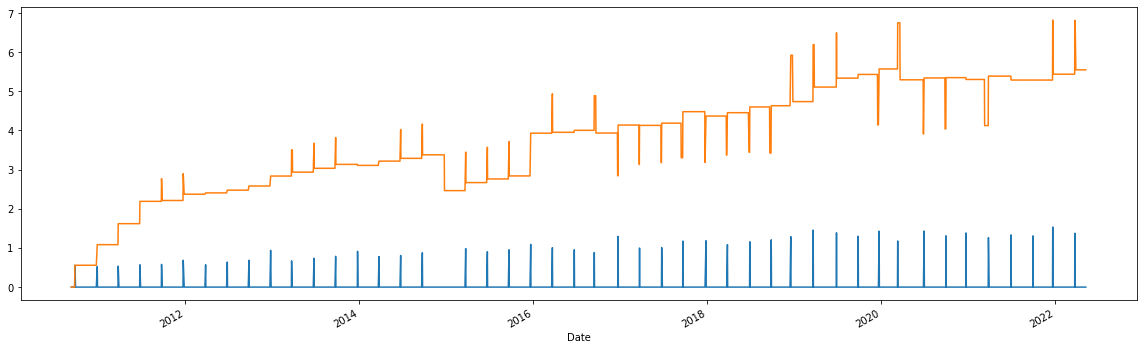

In [325]:
df.set_index('Date')['Dividends'].plot(figsize=(20,6))
df.set_index('Date')['Dividends'].rolling(window='365d').sum().plot()

In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date').rolling(window=365,  min_periods=1).mean()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-01-30,33.574720,33.607853,33.561470,33.561470,6800.000000,0.000000,0.0
2004-02-02,33.578038,33.594604,33.571413,33.571413,3500.000000,0.000000,0.0
2004-02-03,33.579144,33.590188,33.574727,33.574727,2333.333333,0.000000,0.0
2004-02-04,33.616141,33.703938,33.612829,33.692343,2500.000000,0.000000,0.0
2004-02-05,33.692673,33.786765,33.690023,33.777489,2120.000000,0.000000,0.0
...,...,...,...,...,...,...,...
2022-05-03,181.920596,182.830461,181.013621,181.946639,147361.095890,0.018055,0.0
2022-05-04,182.010596,182.928635,181.102443,182.045120,147938.356164,0.018055,0.0
2022-05-05,182.105938,183.024051,181.188100,182.134348,148319.452055,0.018055,0.0


# 추가 지표
- 암호화폐 
    - https://stackoverflow.com/questions/67146805/yfinance-crypto-symbol-list
    - https://investpy.readthedocs.io/_api/crypto.html
- major world indices
    - https://towardsdatascience.com/analyzing-world-stock-indices-performance-in-python-610df6a578f
    - https://investpy.readthedocs.io/_api/indices.html
    - 필요한것
        - 미국 지표
        - 주요국가 대표 지수 -> 모든나라 한 담에 필터링?
        - 한국 지표 
    - investpy
        - 모든 지수를 불러올 수 있지만 yfinance와 티커가 다름
        - 지수는 어차피 open, high, low, close, volume만 알면 되는데 investpy에서도 획득 가능
    - yahoo finance -> yfinance
        - yahoo finance에서 read html 해서 주요 지표 yfinance로 수집
        - 어차피 컬럼은 똑같음
- 환율
    - https://investpy.readthedocs.io/_api/currency_crosses.html
- 소비자물가지수



### yahoo finance 주요 지표

In [5]:
# https://www.inflearn.com/questions/152894
# symbol, Name, category

def get_indices_from_yahoo_finance(url):

    response = requests.get(url)
    html = bs(response.text, "lxml")
    html_table = html.select("table")
    table = pd.read_html(str(html_table))
    df_indices = table[0][['Symbol','Name']]
    df_indices['full_name'] = df_indices['Name']
    df_indices['country'] = None
    df_indices['currency'] = None
    df_indices['category'] = 'index'
    df_indices.columns = df_indices.columns.str.lower().to_list()
    return df_indices

url_world_indices = 'https://finance.yahoo.com/world-indices'
url_futures = 'https://finance.yahoo.com/commodities'
get_indices_from_yahoo_finance(url_world_indices)

,symbol,name,full_name,country,currency,category
0,^GSPC,S&P 500,S&P 500,None,None,index
1,^DJI,Dow 30,Dow 30,None,None,index
2,^IXIC,Nasdaq,Nasdaq,None,None,index
3,^NYA,NYSE COMPOSITE (DJ),NYSE COMPOSITE (DJ),None,None,index
4,^XAX,NYSE AMEX COMPOSITE INDEX,NYSE AMEX COMPOSITE INDEX,None,None,index
5,^BUK100P,Cboe UK 100,Cboe UK 100,None,None,index
6,^RUT,Russell 2000,Russell 2000,None,None,index
7,^VIX,CBOE Volatility Index,CBOE Volatility Index,None,None,index
8,^FTSE,FTSE 100,FTSE 100,None,None,index
9,^GDAXI,DAX PERFORMANCE-INDEX,DAX PERFORMANCE-INDEX,None,None,index


In [ ]:
yf.Ticker('ETH-USD').history(period='max')

### investpy 모든 지표

In [4]:
def get_indices_from_investpy():
    countries = ['united states', 'south korea']
    indices = investpy.indices.get_indices()
    indices = indices[indices['country'].isin(countries)].reset_index(drop=True)
    indices['symbol'] = '^' + indices['symbol']
    indices['category'] = 'index'
    cols = ['symbol', 'name', 'full_name', 'country', 'currency', 'category']
    indices = indices[cols]
    return indices

get_indices_from_investpy().head()

,symbol,name,full_name,country,currency,category
0,^FLKTBINV,F-LKTB Inverse,F-LKTB Inverse,south korea,KRW,index
1,^FLKTB,F-LKTB Index,F-LKTB Index,south korea,KRW,index
2,^FKTBINV,F-KTB Inverse,F-KTB Inverse,south korea,KRW,index
3,^FKTB,F-KTB Index,F-KTB Index,south korea,KRW,index
4,^KRXTRANS,KRX Transportation,KRX Transportation,south korea,KRW,index


In [22]:
dt.datetime.today()

datetime.datetime(2022, 5, 14, 8, 32, 5, 276074)

In [ ]:
# 멀리부터 가져오는 만큼 오래걸림.. 야후가 제일 좋음... # 딜레이 줘보기...
# 후순위로 하자...
investpy.indices.get_index_historical_data('DJ Internet', country='united states', from_date='01/01/2000', to_date='05/05/2022')

In [ ]:
matches = []
no_matches = []
for symbol in tqdm(a['symbol'][:], mininterval=0.5):
    df = yf.Ticker(f'^{symbol}').history(period='max')
    if len(df) > 0:
        print(f'Symbols Match: {symbol}')
        matches.append(symbol)
    else:
        no_matches.append(symbol)

In [ ]:
yf.Ticker('^ks11').history()


### 환율

In [15]:
def get_currencies_from_investpy():
    currencies = investpy.currency_crosses.get_currency_crosses()
    base_cur = ['KRW', 'USD']
    currencies = currencies[currencies['base'].isin(base_cur)].reset_index(drop=True)
    currencies['currency'] = currencies['base']
    currencies['category'] = 'currency'
    currency_to_country = {'USD': 'united states', 'KRW': 'south Korea'}
    currencies['country'] = currencies['currency'].map(currency_to_country)
    def _encode_symbol(name):
        base_cur, second_cur = name.split('/')
        if base_cur == 'USD':
            symbol = f'{second_cur}=X'
        else:
            symbol = f'{base_cur}{second_cur}=X'
        return symbol
    currencies['symbol'] = currencies['name'].apply(_encode_symbol)
    currencies = currencies[['symbol', 'name', 'full_name', 'country', 'currency', 'category']]
    return currencies
get_currencies_from_investpy().head()

,symbol,name,full_name,country,currency,category
0,AED=X,USD/AED,USD/AED - US Dollar UAE Dirham,united states,USD,currency
1,AFN=X,USD/AFN,USD/AFN - US Dollar Afghanistan Afghani,united states,USD,currency
2,ALL=X,USD/ALL,USD/ALL - US Dollar Albanian Lek,united states,USD,currency
3,AMD=X,USD/AMD,USD/AMD - US Dollar Armenian Dram,united states,USD,currency
4,ANG=X,USD/ANG,USD/ANG - US Dollar Antilles Guilder,united states,USD,currency


In [ ]:
yf.Ticker('KRWJPY=X').history(period='max')

### Fred: 기준금리, 소비자물가, 인플레이션 등등
- https://ecodemy.cafe24.com/fedrfund.html
- https://seek-and-eat.tistory.com/88

In [4]:
import pandas_datareader.data as web

In [33]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime.today()
a = web.DataReader('T10Y2Y', 'fred', start, end)
a

,T10Y2Y
DATE,
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2022-05-09,0.44
2022-05-10,0.37
2022-05-11,0.25


### 경제 위기
- https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
- search the word 'recession': https://www.stlouisfed.org/education/-/media/project/frbstl/stlouisfed/education/lessons/pdf/fred-gdp-stacking.pdf
- https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/recession-bars/
- https://blog.stata.com/2020/02/13/adding-recession-shading-to-time-series-graphs/
- https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/recession-bars/
- https://seek-and-eat.tistory.com/88

In [4]:
fred = pd.DataFrame(LIST_DICT_SYMBOLS_FRED)
fred.head()

,symbol,name,full_name,country,currency,category
0,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...,Consumer Price Index for All Urban Consumers: ...,united states,None,index
1,EFFR,Effective Federal Funds Rate,Effective Federal Funds Rate,united states,None,index
2,T10Y2Y,10-Year Treasury Constant Maturity Minus 2-Yea...,10-Year Treasury Constant Maturity Minus 2-Yea...,united states,None,index
3,T10Y3M,10-Year Treasury Constant Maturity Minus 3-Mon...,10-Year Treasury Constant Maturity Minus 3-Mon...,united states,None,index
4,T10YIE,10-Year Breakeven Inflation Rate,10-Year Breakeven Inflation Rate,united states,None,index


In [9]:
# iterrow 보다 itertuple이 훨씬 빠르다고 함

fred = pd.DataFrame(LIST_DICT_SYMBOLS_FRED)
fred.head()

start, end = (dt.datetime(1800, 1, 1), dt.datetime.today())
for row in tqdm(fred[:1].itertuples(), total=len(fred)):
    i = getattr(row, 'Index')
    symbol = getattr(row, 'symbol')
    try:
        history = web.DataReader(symbol, 'fred', start, end).reset_index(drop=False)
        history['country'] = getattr(row, 'country')
        history['symbol'] = getattr(row, 'symbol')
        history['full_name'] = getattr(row, 'full_name')
        history.rename(columns={f'{symbol}':'close'}, inplace=True)
        history.rename(columns={'DATE':'date'}, inplace=True)


        history.to_csv(
            os.path.join(DIRNAME_DOWNLOAD, SUBDIRNAME_HISTORY_INDICES, f'history_{symbol}.csv'),  index=False)
    except:
        print(f'Error Occured at Loop {i}: {symbol}')
history

  0%|          | 0/13 [00:00<?, ?it/s]

,date,close,country,symbol,full_name
0,1947-01-01,21.480,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
1,1947-02-01,21.620,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
2,1947-03-01,22.000,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
3,1947-04-01,22.000,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
4,1947-05-01,21.950,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
...,...,...,...,...,...
899,2021-12-01,280.126,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
900,2022-01-01,281.933,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
901,2022-02-01,284.182,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
902,2022-03-01,287.708,united states,CPIAUCSL,Consumer Price Index for All Urban Consumers: ...


In [2]:
import etl_processor
processor = etl_processor.EtlProcessor()
#recession = processor.get_recession()
# recession['recession'].plot()

In [3]:
a = yf.Ticker('schd').history(period='max').reset_index(drop=False)
#a['yyyy-mm'] = a['Date'].dt.to_period('M').astype('str')
a.rename(columns={'Date': 'date'}, inplace=True)

processor = etl_processor.EtlProcessor()
h = processor._join_recession(a)
h

NameError: name 'yf' is not defined

In [11]:
type(h)

NoneType

In [14]:
a = yf.Ticker('schd').history(period='max').reset_index(drop=False)
a['yyyy-mm'] = a['Date'].dt.to_period('M').astype('str')
a.rename(columns={'Date': 'date'}, inplace=True)

processor = etl_processor.EtlProcessor()
recession = processor.get_recession()

joined = a.merge(recession, how='left', on='yyyy-mm', suffixes=(None,"_y"))
joined['recession'].fillna(0, inplace=True)
joined

,date,Open,High,Low,Close,Volume,Dividends,Stock Splits,yyyy-mm,date_y,recession
0,2011-10-20,18.320743,18.357383,18.115550,18.306086,98900,0.0,0,2011-10,2011-10-01,0.0
1,2011-10-21,18.562573,18.665169,18.496618,18.665169,188800,0.0,0,2011-10,2011-10-01,0.0
2,2011-10-24,19.046238,19.046238,18.672495,18.767763,296600,0.0,0,2011-10,2011-10-01,0.0
3,2011-10-25,18.701814,18.701814,18.452652,18.459980,94400,0.0,0,2011-10,2011-10-01,0.0
4,2011-10-26,18.731121,18.731121,18.401349,18.650511,45000,0.0,0,2011-10,2011-10-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2659,2022-05-16,76.150002,77.019997,75.690002,76.559998,3159600,0.0,0,2022-05,NaT,0.0
2660,2022-05-17,77.480003,78.019997,77.150002,77.949997,2768000,0.0,0,2022-05,NaT,0.0
2661,2022-05-18,77.410004,77.500000,75.279999,75.519997,3627800,0.0,0,2022-05,NaT,0.0
2662,2022-05-19,74.620003,75.180000,73.919998,74.400002,4330100,0.0,0,2022-05,NaT,0.0


In [10]:
start, end = (dt.datetime(1800, 1, 1), dt.datetime.today())
recession = web.DataReader('USREC', 'fred', start, end)
recession = recession.reset_index(drop=False)
recession['yyyy-mm'] = recession['DATE'].dt.to_period('M').astype('str')
recession

,DATE,USREC,yyyy-mm
0,1854-12-01,1,1854-12
1,1855-01-01,0,1855-01
2,1855-02-01,0,1855-02
3,1855-03-01,0,1855-03
4,1855-04-01,0,1855-04
...,...,...,...
2004,2021-12-01,0,2021-12
2005,2022-01-01,0,2022-01
2006,2022-02-01,0,2022-02
2007,2022-03-01,0,2022-03


In [ ]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime.today()
a = web.DataReader('T10Y2Y', 'fred', start, end)
a = a.reset_index(drop=False)
a['yyyy-mm'] = a['DATE'].dt.to_period('M').astype('str')
a

In [ ]:
# 연, 월이 같을 경우 1 할당?
# 연도, 월 컬럼 만들고 join

start = dt.datetime(1900, 1, 1)
end = dt.datetime.today()
df = web.DataReader('USREC', 'fred', start, end)
df = df.reset_index(drop=False)
df['yyyy-mm'] = df['DATE'].dt.to_period('M').astype('str')
df = df[['USREC','yyyy-mm']]
df

In [ ]:
joined = a.merge(df, how='left', on='yyyy-mm')
joined['USREC'].fillna(0, inplace=True)
joined

### Concat Indices Master

In [19]:
indices = []
indices.append(get_indices_from_yahoo_finance(url_world_indices))
indices.append(get_indices_from_yahoo_finance(url_futures))
indices.append(get_indices_from_investpy())
indices.append(get_currencies_from_investpy())
indices_master = pd.concat(indices)
indices_master

,symbol,name,full_name,country,currency,category
0,^GSPC,S&P 500,S&P 500,None,None,index
1,^DJI,Dow 30,Dow 30,None,None,index
2,^IXIC,Nasdaq,Nasdaq,None,None,index
3,^NYA,NYSE COMPOSITE (DJ),NYSE COMPOSITE (DJ),None,None,index
4,^XAX,NYSE AMEX COMPOSITE INDEX,NYSE AMEX COMPOSITE INDEX,None,None,index
...,...,...,...,...,...,...
155,XCD=X,USD/XCD,USD/XCD - US Dollar East Caribbean Dollar,united states,USD,currency
156,XOF=X,USD/XOF,USD/XOF - US Dollar West African CFA franc,united states,USD,currency
157,XPF=X,USD/XPF,USD/XPF - US Dollar French Pacific Franc,united states,USD,currency
158,YER=X,USD/YER,USD/YER - US Dollar Yemeni Rial,united states,USD,currency


In [ ]:
etf_master = construct_etf_master()
etf_master

In [24]:
pd.concat([etf_master, indices_master])

,country,symbol,name,full_name,currency,category,fund_family,expense_ratio,inception_date,net_assets,nav,isin,stock_exchange,52_week_range,dividends_ttm,volume,market_cap,dividend_yield_rate,average_vol_3m,total_assets,1_year_change_rate
0,united states,SPDV,AAM S&P 500 Sector High Dividend,AAM S&P 500 Sector High Dividend,USD,equity,AAM,0.29,2017-11-28,60.62M,31.57,US26922A5948,NYSE,28.48 - 33.39,1.0329,62667.0,57600000.0,0.0327,10707.0,NaN,0.0144
1,united states,EEMD,AAM S&P EM Sector High Dividend,AAM S&P Emerging Markets Sector High Dividend,USD,equity,AAM,0.49,2017-11-28,7.25M,20.08,US26922A5864,NYSE,19.67 - 24.04,1.1657,3886.0,7020000.0,0.0581,3207.0,NaN,-0.1447
2,united states,ZIG,The Acquirers Fund,The Acquirers Fund ETF,USD,equity,Acquirers Funds,0.89,2019-05-14,41.75M,26.77,US26922A2630,NYSE,25.94 - 31.88,0.0575,1765.0,42150000.0,0.0022,6464.0,NaN,-0.0180
3,united states,HDGE,Ranger Equity Bear,Ranger Equity Bear,USD,equity,AdvisorShares,5.20,2011-01-26,122.66M,28.86,US00768Y8839,NYSE,22.67 - 29.49,NaN,213867.0,77170000.0,NaN,137474.0,163390000.0,0.1768
4,united states,DWSH,AdvisorShares Dorsey Wright Short,AdvisorShares Dorsey Wright Short,USD,equity,AdvisorShares,3.68,2018-07-10,32.13M,9.44,US00768Y5298,NASDAQ,8.09 - 9.89,NaN,79275.0,35040000.0,NaN,54141.0,NaN,0.0623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,united states,XCD=X,USD/XCD,USD/XCD - US Dollar East Caribbean Dollar,USD,currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,united states,XOF=X,USD/XOF,USD/XOF - US Dollar West African CFA franc,USD,currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,united states,XPF=X,USD/XPF,USD/XPF - US Dollar French Pacific Franc,USD,currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,united states,YER=X,USD/YER,USD/YER - US Dollar Yemeni Rial,USD,currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
yf.Ticker('^ks11').history(period='max')


In [ ]:
#yf.Ticker('EURUSD=X').history()
yf.Ticker('EUR=X').history(period='max')
#yf.Ticker('BTC-KRW').history()
#yf.Ticker('^ks11').history(period='max')


# Summary에 들어갈 지표
- 기간별(1,3,6,12개월)
    - 변동폭(과거 가격 대비) -> ROI?
    - 변동률(과거 가격 대비)
    - 모멘텀
    - 고가, 저가
- 3개월 평균 거래량
- 배당
    - 발표기관별
    - 내가 구한 것

- master
- hisotry
- summary
    - 끌어올 수 있는 거
    - 직접 구해야 하는거
        - 배당률 -> T12M, T6M
        - 최근 1년 배당 횟수 -> 반기, 분기, 연

- market cap
    - 시총
- shares outstanding(https://www.mk.co.kr/dic/m/view.php?idx=6091)
    - 발행주식수
    - 기업이 발행하여 일반 투자자가 소유하고 있는 주식수
- AUM(assets under management)
    - The AUM of an ETF is calculated by multiplying shares outstanding by the market price per share
    - shares outstanding * 주당 가격
- total asset: 